# Projeto de Previsão de Diabetes

**Objetivo:** Este notebook tem como objetivo construir e avaliar modelos de Machine Learning para prever a ocorrência de diabetes com base em um conjunto de variáveis diagnósticas.

**Dataset:** Utilizaremos o dataset "Pima Indians Diabetes Database", disponível publicamente (mencione a fonte se souber, ex: Kaggle).

**Metodologia:**
1.  Importação das bibliotecas necessárias.
2.  Carregamento e exploração inicial dos dados (EDA).
3.  Pré-processamento dos dados:
    *   Renomear colunas.
    *   Tratamento de valores implausíveis (zeros em certas colunas).
    *   Análise de balanceamento da variável alvo.
4.  Engenharia de Features e Separação Treino/Teste:
    *   Separação inicial dos dados.
    *   Aplicação e comparação de diferentes técnicas de escalonamento (StandardScaler, MinMaxScaler, Misto).
    *   Aplicação de balanceamento (SMOTE) **apenas nos dados de treino**.
5.  Treinamento de Modelos Individuais (Opcional/Baseline):
    *   Treinar modelos básicos nos dados (possivelmente originais ou com um tipo de pré-processamento).
    *   Avaliação inicial.
6.  Avaliação Sistemática com Pipelines:
    *   Criar pipelines combinando pré-processamento, balanceamento (SMOTE) e um modelo (ex: RandomForest).
    *   Comparar o desempenho das diferentes estratégias de pré-processamento.
7.  Conclusão: Resumo dos resultados e escolha da melhor abordagem.

**Observação:** Este notebook explora diferentes técnicas de pré-processamento e balanceamento para entender seu impacto no desempenho do modelo.

## 1. Importação de Bibliotecas

Nesta seção, importamos todas as bibliotecas que serão utilizadas ao longo do projeto, organizadas por funcionalidade.

In [4]:
# [CÓDIGO - Bloco 01: Importações]
# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# from pandasgui import show # Comentar ou remover se não for essencial para o notebook final no GitHub

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE # Para balanceamento

# Model Selection & Splitting
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # Se usou XGBoost

# Metrics & Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline Tools
from imblearn.pipeline import make_pipeline # Pipeline da imblearn

# Utilities
import warnings
import locale
import os

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) # Talvez remover para não poluir outputs longos no GitHub
#pd.options.display.float_format = '{:.2f}'.format
# locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8') # Ajuste conforme necessário

## 2. Carregamento e Exploração Inicial dos Dados (EDA)

Carregamos o dataset e realizamos uma análise exploratória inicial para entender sua estrutura, tipos de dados, presença de valores ausentes e estatísticas descritivas básicas.

In [6]:
# [CÓDIGO - Bloco 02: Carregamento]
nome_arquivo = '../data/Diabetes.csv'
df = pd.read_csv(nome_arquivo)

### 2.1 Visualização Inicial (Head & Tail)
Verificamos as primeiras e últimas linhas para ter uma ideia geral dos dados.

In [7]:
# [CÓDIGO - Bloco 03: Head]
print("Primeiras 5 linhas:")
display(df.head())

# [CÓDIGO - Bloco 04: Tail]
print("\nÚltimas 5 linhas:")
display(df.tail())

Primeiras 5 linhas:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Últimas 5 linhas:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


### 2.2 Informações Gerais e Dimensões
Verificamos os tipos de dados, contagem de valores não nulos e as dimensões do DataFrame (linhas, colunas).

In [11]:
# [CÓDIGO - Bloco 05: Info]
print("\nInformações do DataFrame:")
df.info()

# [CÓDIGO - Bloco 06: Shape]
print("\nShape (Linhas, Colunas):")
print(df.shape)


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Shape (Linhas, Colunas):
(768, 9)


*Interpretação:* O dataset possui X linhas e Y colunas. Todas as colunas parecem ser numéricas (int64 ou float64), o que é esperado para este dataset. Não há valores nulos (`NaN`) reportados pelo `.info()`, mas precisaremos investigar valores 'zero' que podem ser implausíveis.

### 2.3 Nomes das Colunas e Valores Únicos
Listamos as colunas e verificamos a quantidade de valores únicos em cada uma.

In [12]:
# [CÓDIGO - Bloco 07: Columns]
print("\nColunas:")
print(df.columns)

# [CÓDIGO - Bloco 08: Nunique]
print("\nValores Únicos por Coluna:")
print(df.nunique())


Colunas:
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Valores Únicos por Coluna:
Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


### 2.4 Verificação de Nulos e Duplicados
Confirmamos a ausência de valores nulos padrão e procuramos por linhas duplicadas.

In [13]:
# [CÓDIGO - Bloco 09: IsNull]
print("\nContagem de Valores Nulos por Coluna:")
print(df.isnull().sum())

# [CÓDIGO - Bloco 10: Duplicated]
print("\nLinhas Duplicadas:")
duplicadas = df[df.duplicated(keep=False)]
if duplicadas.empty:
    print("Nenhuma linha duplicada encontrada.")
else:
    display(duplicadas)
    # Opcional: Decidir se remove ou não as duplicadas
    # df = df.drop_duplicates()


Contagem de Valores Nulos por Coluna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Linhas Duplicadas:
Nenhuma linha duplicada encontrada.


*Interpretação:* Não foram encontrados valores nulos (`NaN`) nem linhas duplicadas no dataset.

### 2.5 Estatísticas Descritivas
Analisamos as estatísticas descritivas para entender a distribuição de cada variável (média, mediana, desvio padrão, quartis, mínimos e máximos).

In [14]:
# [CÓDIGO - Bloco 11: Describe]
print("\nEstatísticas Descritivas:")
display(df.describe())


Estatísticas Descritivas:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


*Interpretação:* Observamos pontos importantes:
*   Colunas como 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' possuem valor mínimo igual a zero. Isso é biologicamente implausível para a maioria delas e provavelmente indica dados ausentes ou inválidos que precisam ser tratados.
*   As escalas das variáveis são bastante diferentes (compare 'Insulin' com 'Pregnancies'), indicando a necessidade de escalonamento antes de usar modelos sensíveis à escala (como SVM, KNN, Regressão Logística).
*   A coluna 'Outcome' (nosso alvo) é binária (0 ou 1).

## 3. Pré-processamento dos Dados

Nesta etapa, preparamos os dados para a modelagem, incluindo renomeação de colunas e tratamento de valores implausíveis.

### 3.1 Renomear Colunas
Traduzimos os nomes das colunas para português para facilitar a interpretação.

In [15]:
# [CÓDIGO - Bloco 12: Rename]
df.rename(columns={
    "Pregnancies": "Gravidez",
    "Glucose": "Glicose",
    "BloodPressure": "Pressão arterial",
    "SkinThickness": "Espessura da pele",
    "Insulin": "Insulina",
    "BMI": "IMC",
    "DiabetesPedigreeFunction": "Diabetes Descendente",
    "Age": "Idade",
    "Outcome": "Resultado"
}, inplace=True)

print("\nColunas após renomear:")
print(df.columns)
# df.info() # Opcional, para confirmar


Colunas após renomear:
Index(['Gravidez', 'Glicose', 'Pressão arterial', 'Espessura da pele',
       'Insulina', 'IMC', 'Diabetes Descendente', 'Idade', 'Resultado'],
      dtype='object')


### 3.2 Visualização de Outliers/Distribuição (Antes do Tratamento de Zeros)
Usamos boxplots para visualizar a distribuição e potenciais outliers em cada variável *antes* de tratar os valores zero.

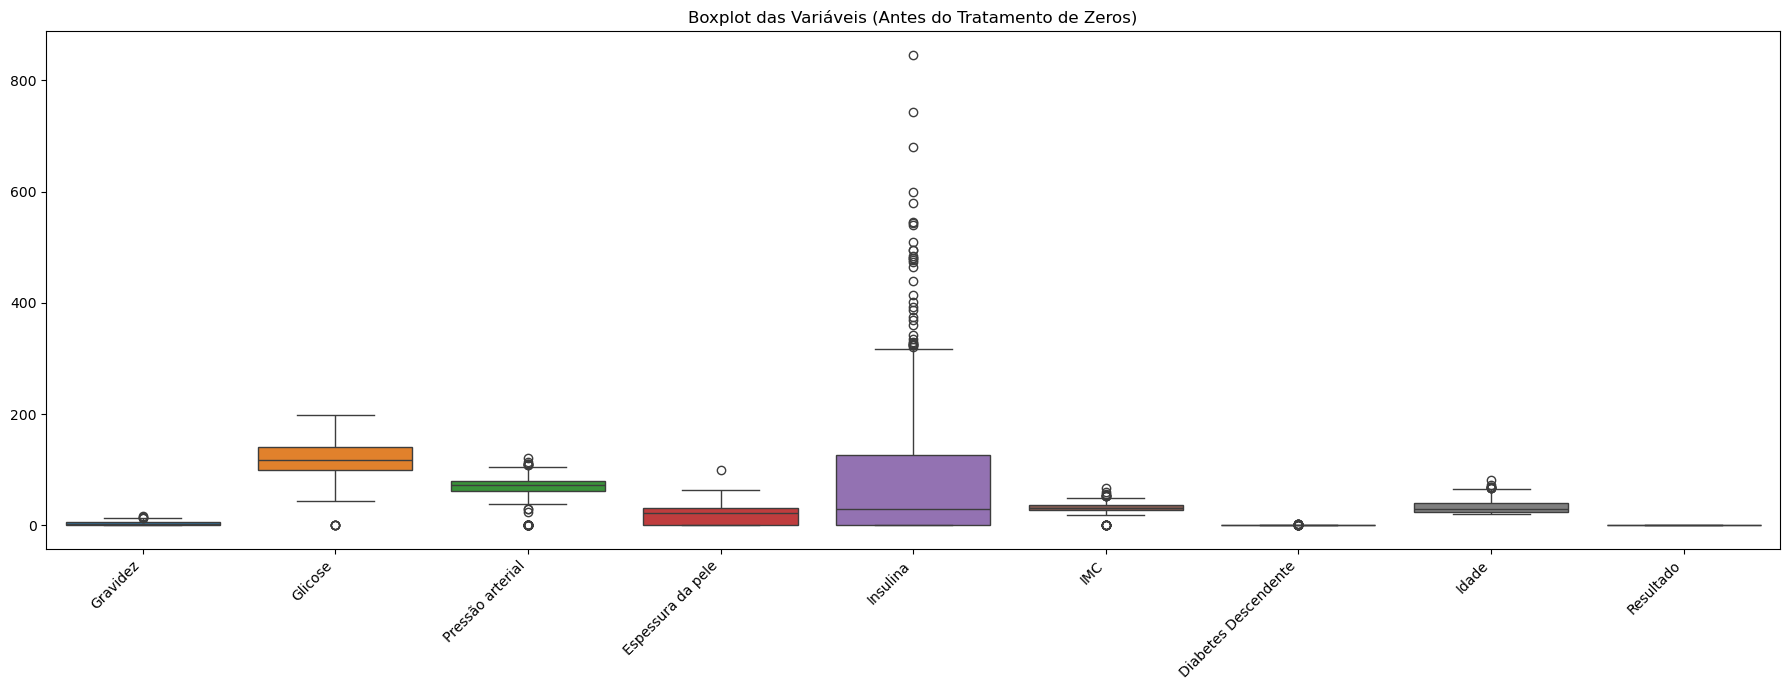

In [16]:
# [CÓDIGO - Bloco 13: Boxplot Antes]
plt.figure(figsize=(18, 7))
sns.boxplot(data=df)
plt.title("Boxplot das Variáveis (Antes do Tratamento de Zeros)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Interpretação:* O boxplot confirma visualmente a presença de muitos valores 'zero' nas colunas mencionadas ('Glicose', 'Pressão arterial', etc.) e a variação nas escalas e presença de outliers.

### 3.3 Tratamento de Valores Zero Implausíveis
Substituímos os valores zero nas colunas 'Glicose', 'Pressão arterial', 'Espessura da pele', 'Insulina' e 'IMC' pela *mediana* calculada *excluindo* os zeros. A mediana é usada por ser mais robusta a outliers do que a média.

In [17]:
# [CÓDIGO - Bloco 14: Tratamento de Zeros]
colunas_para_imputar = ['Glicose', 'Pressão arterial', 'Espessura da pele', 'Insulina', 'IMC']
print("Valores médios ANTES da imputação (apenas para comparação):")
print(df[colunas_para_imputar].replace(0, np.nan).mean()) # Calcula média ignorando zeros

print("\n--- Iniciando Imputação com Mediana (sem zeros) ---")
for coluna in colunas_para_imputar:
    # Calcula a mediana ignorando os zeros existentes
    mediana_coluna = df.loc[df[coluna] > 0, coluna].median()

    if pd.isna(mediana_coluna):
        print(f"Aviso: Mediana não-zero não calculada para '{coluna}'. Verifique os dados.")
        # Estratégia alternativa se necessário (ex: usar média geral, mas menos ideal)
        # mediana_coluna = df[coluna].median() # Usaria a mediana incluindo zeros
        continue

    print(f"Coluna: '{coluna}' - Mediana (sem zeros): {mediana_coluna:.2f} - Zeros encontrados: {df[coluna].eq(0).sum()}")

    # Imputa os zeros com a mediana calculada
    df.loc[df[coluna] == 0, coluna] = mediana_coluna

print("--- Imputação Concluída ---")

# Verificação
print("\nZeros restantes nas colunas imputadas:")
print((df[colunas_para_imputar] == 0).sum())

print("\nNovas estatísticas descritivas (colunas imputadas):")
display(df[colunas_para_imputar].describe())

Valores médios ANTES da imputação (apenas para comparação):
Glicose              121.686763
Pressão arterial      72.405184
Espessura da pele     29.153420
Insulina             155.548223
IMC                   32.457464
dtype: float64

--- Iniciando Imputação com Mediana (sem zeros) ---
Coluna: 'Glicose' - Mediana (sem zeros): 117.00 - Zeros encontrados: 5
Coluna: 'Pressão arterial' - Mediana (sem zeros): 72.00 - Zeros encontrados: 35
Coluna: 'Espessura da pele' - Mediana (sem zeros): 29.00 - Zeros encontrados: 227
Coluna: 'Insulina' - Mediana (sem zeros): 125.00 - Zeros encontrados: 374
Coluna: 'IMC' - Mediana (sem zeros): 32.30 - Zeros encontrados: 11
--- Imputação Concluída ---

Zeros restantes nas colunas imputadas:
Glicose              0
Pressão arterial     0
Espessura da pele    0
Insulina             0
IMC                  0
dtype: int64

Novas estatísticas descritivas (colunas imputadas):


,Glicose,Pressão arterial,Espessura da pele,Insulina,IMC
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.656250,72.386719,29.108073,140.671875,32.455208
std,30.438286,12.096642,8.791221,86.383060,6.875177
min,44.000000,24.000000,7.000000,14.000000,18.200000
25%,99.750000,64.000000,25.000000,121.500000,27.500000
50%,117.000000,72.000000,29.000000,125.000000,32.300000
75%,140.250000,80.000000,32.000000,127.250000,36.600000
max,199.000000,122.000000,99.000000,846.000000,67.100000


*Interpretação:* Os valores zero foram substituídos com sucesso. As estatísticas descritivas (especialmente o valor mínimo) agora refletem valores mais plausíveis para essas variáveis.

### 3.4 Visualização de Outliers/Distribuição (Após Tratamento de Zeros)
Replotamos os boxplots para ver o efeito da imputação.

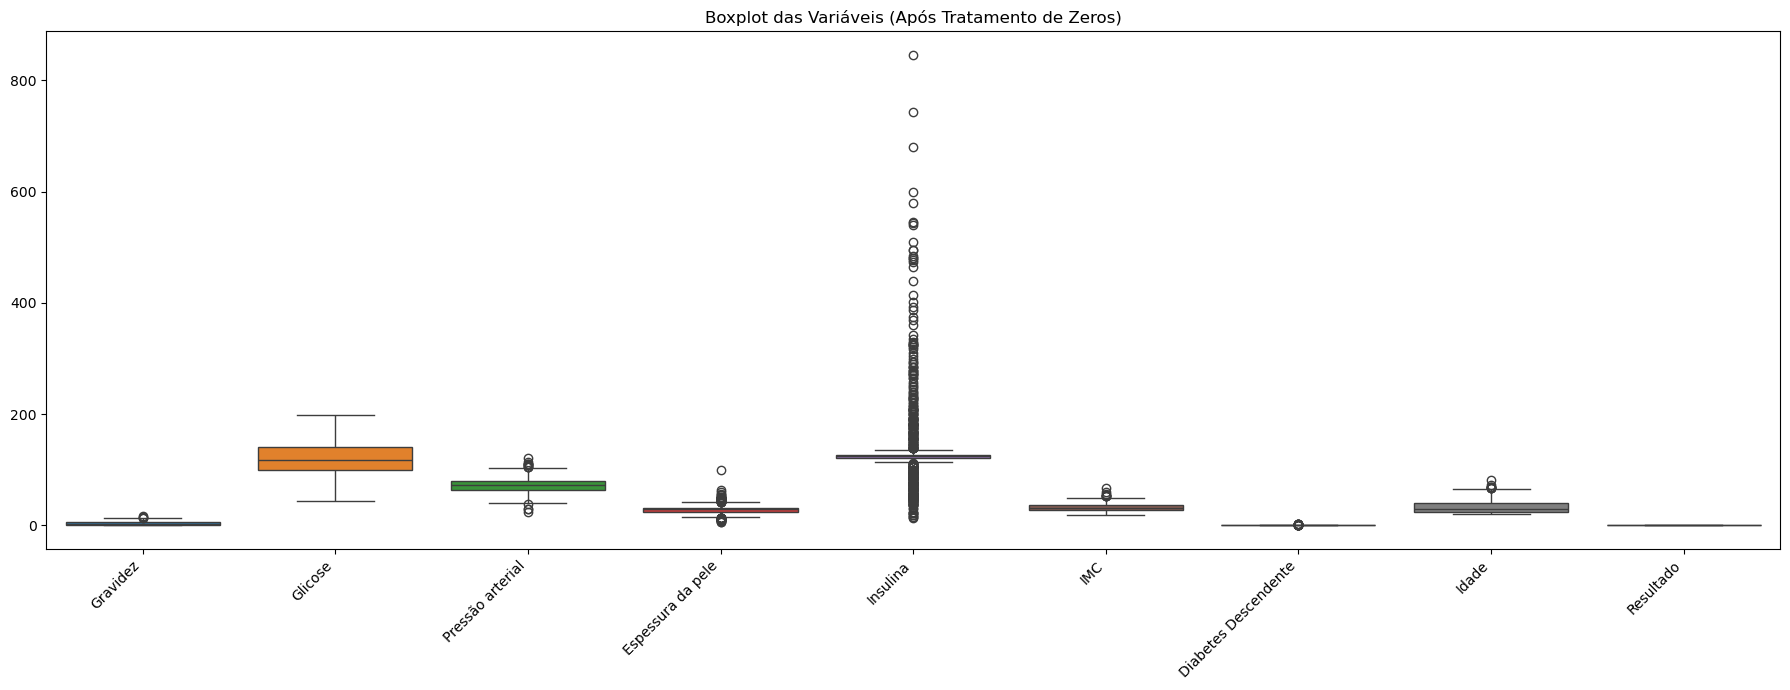

In [18]:
# [CÓDIGO - Bloco 15: Boxplot Depois]
plt.figure(figsize=(18, 7))
sns.boxplot(data=df)
plt.title("Boxplot das Variáveis (Após Tratamento de Zeros)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Interpretação:* As distribuições parecem mais razoáveis, embora ainda existam outliers e diferenças de escala que serão tratados pelo escalonamento.

### 3.5 Análise de Balanceamento da Variável Alvo ('Resultado')
Verificamos a proporção de classes na variável alvo para identificar desbalanceamento.

Contagem de Classes na Variável 'Resultado':
Resultado
0    500
1    268
Name: count, dtype: int64

Proporção (Classe 0 / Classe 1): 1.87:1


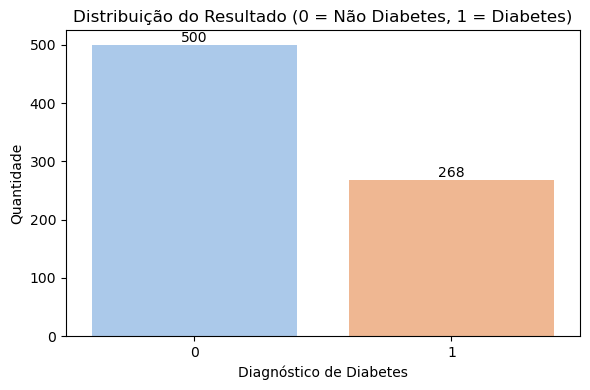

In [19]:
# [CÓDIGO - Bloco 16: Value Counts Target]
target_count = df['Resultado'].value_counts()
print("Contagem de Classes na Variável 'Resultado':")
print(target_count)
print(f"\nProporção (Classe 0 / Classe 1): {target_count[0]/target_count[1]:.2f}:1")

# [CÓDIGO - Bloco 17: Countplot Target]
plt.figure(figsize=(6, 4))
plt.title("Distribuição do Resultado (0 = Não Diabetes, 1 = Diabetes)")
sns.countplot(x='Resultado', data=df, palette='pastel')
plt.xlabel("Diagnóstico de Diabetes")
plt.ylabel("Quantidade")
# Adiciona contagens no topo das barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

*Interpretação:* O dataset é **desbalanceado**. Existem aproximadamente X casos de não-diabéticos (classe 0) para cada Y caso de diabético (classe 1). Isso significa que a acurácia por si só pode não ser uma boa métrica. Precisaremos usar técnicas como SMOTE para balancear os dados de treino e/ou focar em métricas como Recall, Precision e F1-Score, especialmente para a classe minoritária (1).

## 4. Preparação para Modelagem: Separação e Escalonamento

Nesta seção, separamos os dados em conjuntos de treino e teste e aplicamos diferentes técnicas de escalonamento, combinadas com balanceamento SMOTE nos dados de treino.

In [20]:
# [CÓDIGO - Bloco 18: Separa X e Y]
# Separando as features (X) e o target (Y)
X = df.drop('Resultado', axis=1)
y = df['Resultado'] # Nome correto é 'y', não 'Y' por convenção
print("Dimensões de X (features):", X.shape)
print("Dimensões de y (target):", y.shape)

Dimensões de X (features): (768, 8)
Dimensões de y (target): (768,)


In [21]:
# [CÓDIGO - Bloco 19: Train/Test Split Principal]
# Dividindo em conjuntos de treino (70%) e teste (30%)
# Usamos stratify=y para manter a proporção das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42, # Para reprodutibilidade
    stratify=y
)

print("Dimensões dos Conjuntos de Treino:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("\nDimensões dos Conjuntos de Teste:")
print("X_test:", X_test.shape, " y_test:", y_test.shape)

print("\nDistribuição do target no treino:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição do target no teste:")
print(y_test.value_counts(normalize=True))

Dimensões dos Conjuntos de Treino:
X_train: (537, 8)  y_train: (537,)

Dimensões dos Conjuntos de Teste:
X_test: (231, 8)  y_test: (231,)

Distribuição do target no treino:
Resultado
0    0.651769
1    0.348231
Name: proportion, dtype: float64

Distribuição do target no teste:
Resultado
0    0.649351
1    0.350649
Name: proportion, dtype: float64


*Observação:* Separamos os dados ANTES de aplicar qualquer escalonamento ou balanceamento para evitar *data leakage* (informação do conjunto de teste "vazar" para o treino). O escalonamento será ajustado (`fit`) **apenas** no `X_train` e depois aplicado (`transform`) em `X_train` e `X_test`. O balanceamento SMOTE será aplicado **apenas** no `X_train` e `y_train` **após** o escalonamento.

### 4.1 Estratégia 1: Padronização (StandardScaler) + SMOTE
Padroniza as features para terem média 0 e desvio padrão 1. Adequado para algoritmos que assumem distribuição normal ou são sensíveis a outliers de forma moderada.

Formato X_train após StandardScaler: (537, 8)

Formato X_train após SMOTE: (700, 8)
Distribuição do target no treino após SMOTE:
Resultado
1    350
0    350
Name: count, dtype: int64


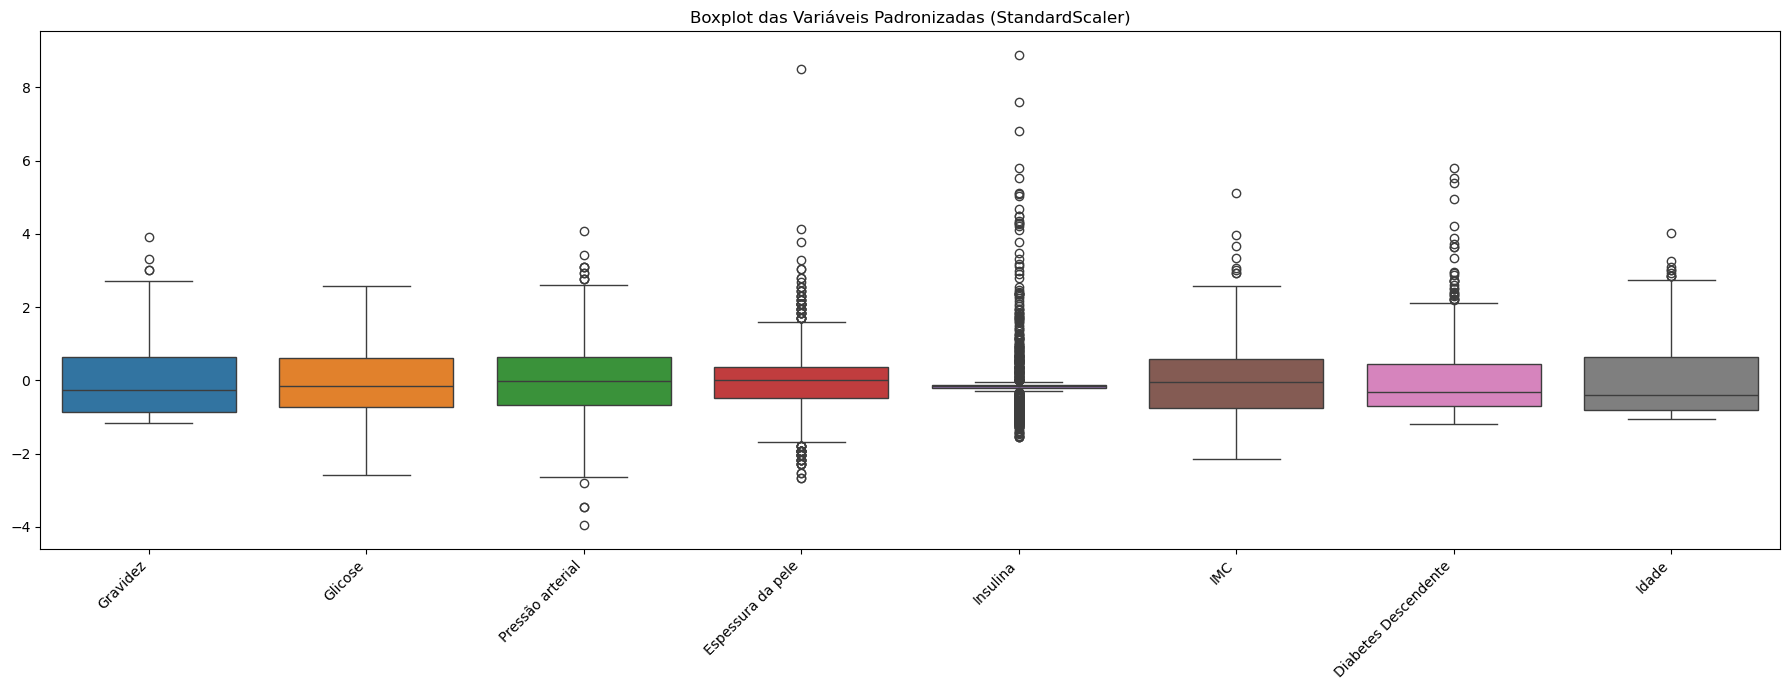

In [22]:
# [CÓDIGO - Bloco 21 & 22 combinado: StandardScaler + SMOTE]

# 1. Inicializar e ajustar o Scaler SOMENTE no treino
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test) # Apenas transforma o teste

print("Formato X_train após StandardScaler:", X_train_std.shape)

# 2. Aplicar SMOTE SOMENTE nos dados de treino já padronizados
smote = SMOTE(random_state=42)
X_train_std_bal, y_train_std_bal = smote.fit_resample(X_train_std, y_train)

print("\nFormato X_train após SMOTE:", X_train_std_bal.shape)
print("Distribuição do target no treino após SMOTE:")
print(pd.Series(y_train_std_bal).value_counts())

# Opcional: Visualizar dados padronizados (ex: boxplot)
# [CÓDIGO - Bloco 24: Boxplot Padronizado (aplicado a X_train_std_bal ou todo X padronizado)]
# Cuidado ao criar df_padronizado - não usar para treino/teste diretamente
df_padronizado_vis = pd.DataFrame(scaler_std.transform(X), columns=X.columns) # Para visualização
plt.figure(figsize=(18, 7))
sns.boxplot(data=df_padronizado_vis)
plt.title("Boxplot das Variáveis Padronizadas (StandardScaler)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.2 Estratégia 2: Normalização (MinMaxScaler) + SMOTE
Normaliza as features para um intervalo específico, geralmente [0, 1]. Útil quando os algoritmos não assumem distribuição normal (como KNN) ou quando se quer limites definidos. Pode ser sensível a outliers.

Formato X_train após MinMaxScaler: (537, 8)

Formato X_train após SMOTE: (700, 8)
Distribuição do target no treino após SMOTE:
Resultado
1    350
0    350
Name: count, dtype: int64


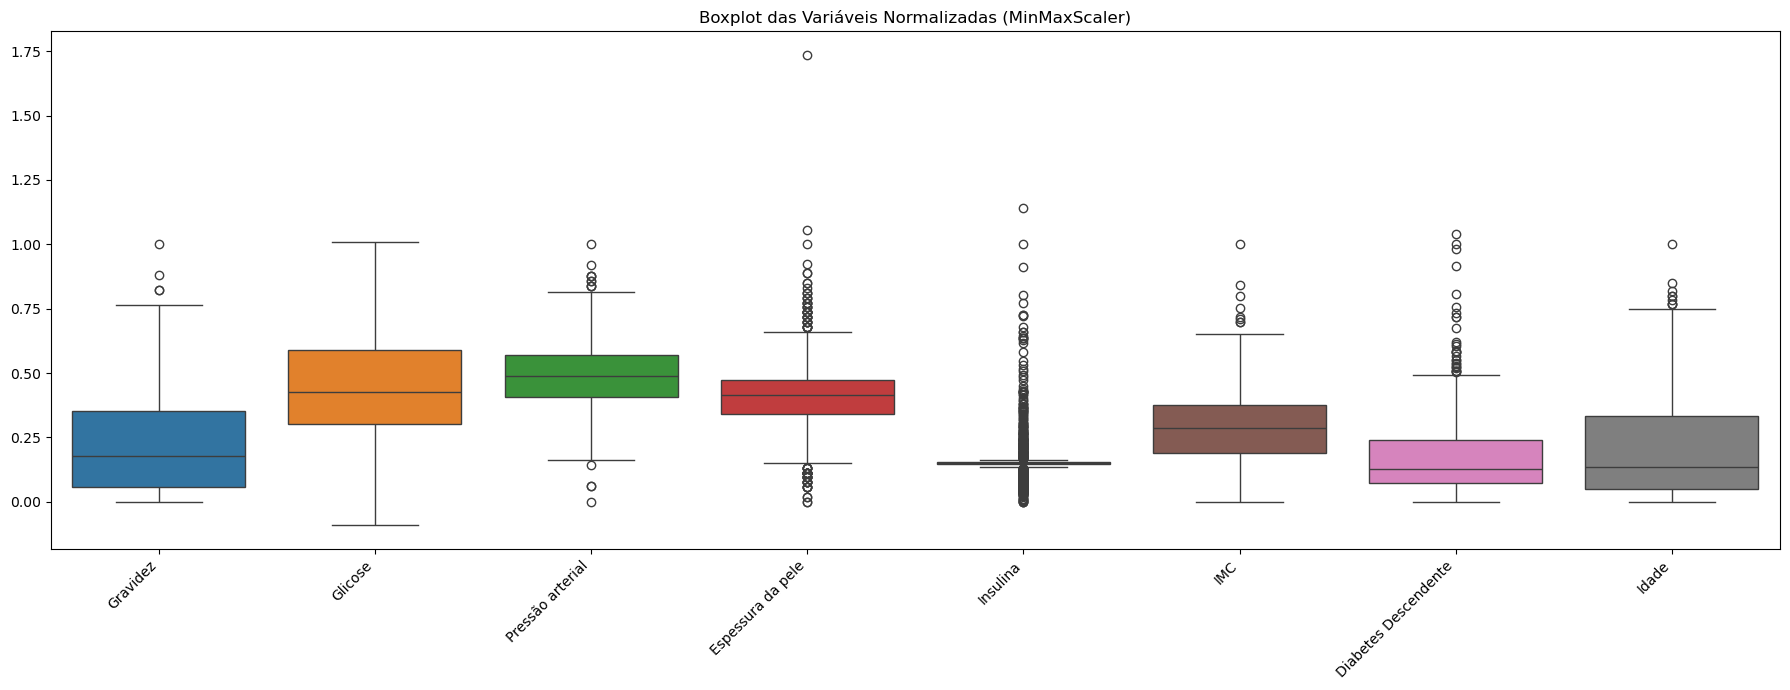

In [23]:
# [CÓDIGO - Bloco 25 & 26 combinado: MinMaxScaler + SMOTE]

# 1. Inicializar e ajustar o Scaler SOMENTE no treino
scaler_minmax = MinMaxScaler()
X_train_norm = scaler_minmax.fit_transform(X_train)
X_test_norm = scaler_minmax.transform(X_test) # Apenas transforma o teste

print("Formato X_train após MinMaxScaler:", X_train_norm.shape)

# 2. Aplicar SMOTE SOMENTE nos dados de treino já normalizados
# Reinstanciar SMOTE ou usar o mesmo objeto
# smote = SMOTE(random_state=42) # Já instanciado
X_train_norm_bal, y_train_norm_bal = smote.fit_resample(X_train_norm, y_train)

print("\nFormato X_train após SMOTE:", X_train_norm_bal.shape)
print("Distribuição do target no treino após SMOTE:")
print(pd.Series(y_train_norm_bal).value_counts())

# Opcional: Visualizar dados normalizados
# [CÓDIGO - Bloco 28: Boxplot Normalizado]
df_normalizado_vis = pd.DataFrame(scaler_minmax.transform(X), columns=X.columns) # Para visualização
plt.figure(figsize=(18, 7))
sns.boxplot(data=df_normalizado_vis)
plt.title("Boxplot das Variáveis Normalizadas (MinMaxScaler)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.3 Estratégia 3: Escalonamento Misto (ColumnTransformer) + SMOTE
Aplica diferentes scalers a diferentes colunas, baseado em suas características. Aqui, usamos RobustScaler (bom para outliers) em algumas, StandardScaler em outras, e deixamos algumas sem escalar ('passthrough').

Nomes das features após ColumnTransformer: ['robust__Insulina' 'robust__Espessura da pele' 'robust__IMC'
 'robust__Diabetes Descendente' 'robust__Gravidez' 'standard__Glicose'
 'standard__Pressão arterial' 'standard__Idade']
Formato X_train após Misto: (537, 8)

Formato X_train após SMOTE: (700, 8)
Distribuição do target no treino após SMOTE:
Resultado
1    350
0    350
Name: count, dtype: int64


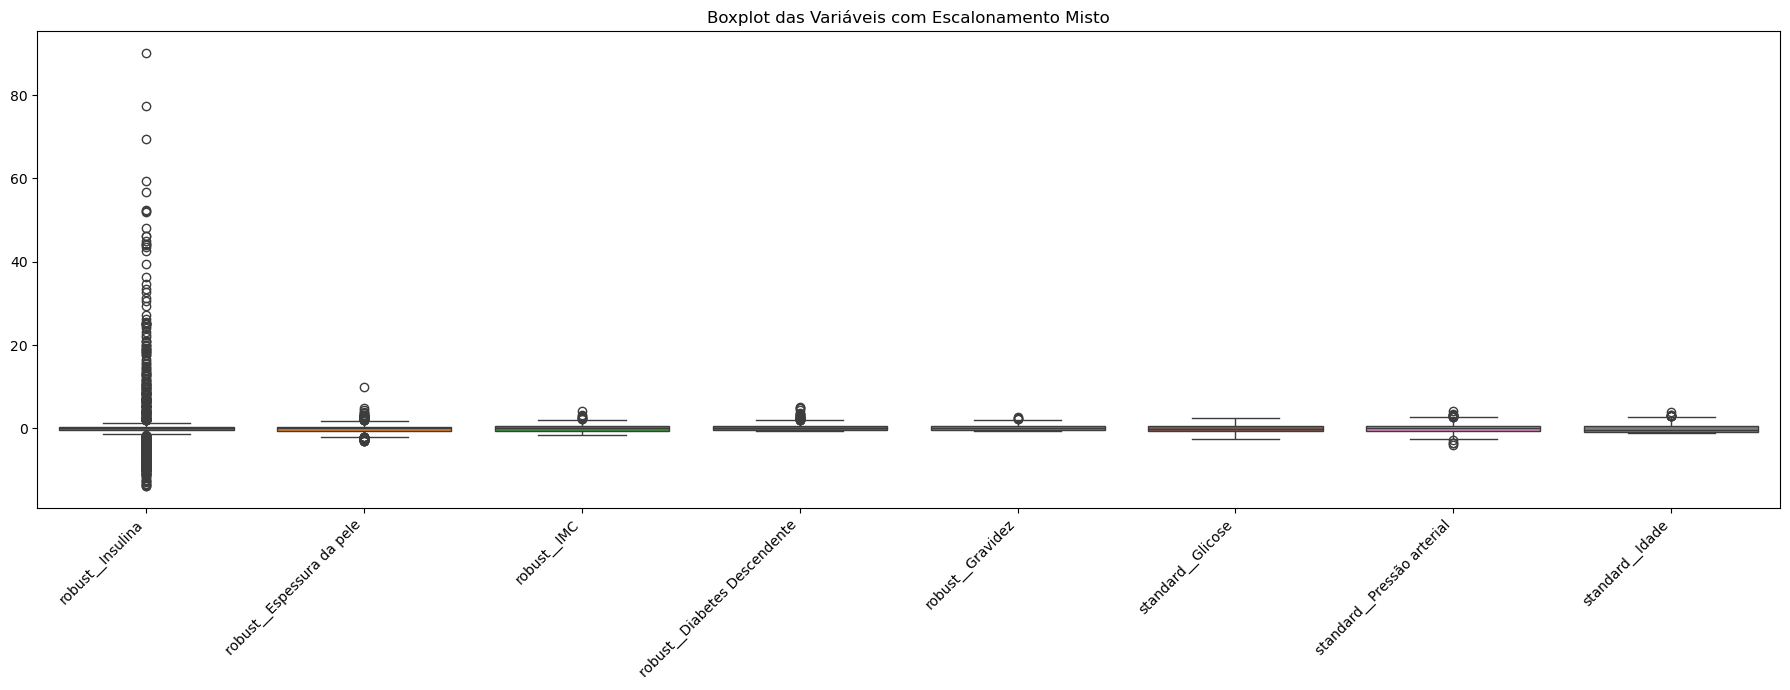

In [24]:
# [CÓDIGO - Bloco 29 & 30 combinado: Mixed Scaling + SMOTE]

# 1. Definir colunas e criar o ColumnTransformer
colunas_robust = ['Insulina', 'Espessura da pele', 'IMC', 'Diabetes Descendente', 'Gravidez'] # Adicionei mais algumas que podem ter outliers
colunas_standard = ['Glicose', 'Pressão arterial', 'Idade'] # Idade pode ir aqui ou passthrough
# As colunas restantes (se houver) serão tratadas pelo 'remainder'

transformer_misto = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), colunas_robust),
        ('standard', StandardScaler(), colunas_standard)
    ],
    remainder='passthrough' # Mantém as colunas não especificadas (se houver)
    # Ou remainder='drop' se quiser descartá-las
)

# 2. Ajustar o Transformer SOMENTE no treino e transformar treino/teste
X_train_misto = transformer_misto.fit_transform(X_train)
X_test_misto = transformer_misto.transform(X_test)

# Obter nomes das features após transformação (importante!)
feature_names_misto = transformer_misto.get_feature_names_out()
print("Nomes das features após ColumnTransformer:", feature_names_misto)
print("Formato X_train após Misto:", X_train_misto.shape)

# 3. Aplicar SMOTE SOMENTE nos dados de treino já transformados
X_train_misto_bal, y_train_misto_bal = smote.fit_resample(X_train_misto, y_train)

print("\nFormato X_train após SMOTE:", X_train_misto_bal.shape)
print("Distribuição do target no treino após SMOTE:")
print(pd.Series(y_train_misto_bal).value_counts())

# Opcional: Visualizar dados mistos
# [CÓDIGO - Bloco 32: Boxplot Misto]
# Cuidado ao criar df_misto - usar nomes corretos das features
df_misto_vis = pd.DataFrame(transformer_misto.transform(X), columns=feature_names_misto) # Para visualização
plt.figure(figsize=(18, 7))
sns.boxplot(data=df_misto_vis)
plt.title("Boxplot das Variáveis com Escalonamento Misto")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Treinamento e Avaliação de Modelos (Baseline - Opcional)

Nesta seção (opcional), treinamos alguns modelos diretamente nos dados de treino *originais* (ou com apenas uma das transformações, ex: padronizados mas *sem* balanceamento) para ter um baseline de comparação.

**Importante:** Para uma comparação justa das estratégias de pré-processamento, a seção seguinte usando Pipelines é mais recomendada.

In [25]:
# [CÓDIGO - Bloco 33 & 34: Split para Baseline (se diferente do principal)]
# Se for usar os dados originais (X_train, y_train) definidos antes, não precisa repetir o split.
# Se for usar dados diferentes (ex: sem SMOTE), defina aqui.
# Ex: Usando dados padronizados SEM balanceamento
# X_train_baseline = X_train_std
# y_train_baseline = y_train
# X_test_baseline = X_test_std
# y_test_baseline = y_test

# Usando dados originais (como no seu código original)
X_train_baseline = X_train
y_train_baseline = y_train
X_test_baseline = X_test
y_test_baseline = y_test

print("Usando dados de treino originais para baseline.")

# [CÓDIGO - Blocos 35 a 39: Treinamento dos Modelos Baseline]
modelos_baseline = {
    "Regressão Logística": LogisticRegression(random_state=42, max_iter=1000), # Aumentar max_iter pode ser necessário
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), # Parâmetros comuns para XGB
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42)
}

resultados_baseline = {}

print("\n--- Treinando Modelos Baseline ---")
for nome, modelo in modelos_baseline.items():
    print(f"Treinando {nome}...")
    modelo.fit(X_train_baseline, y_train_baseline)
    y_pred = modelo.predict(X_test_baseline)
    resultados_baseline[nome] = y_pred
print("--- Treinamento Baseline Concluído ---")

# [CÓDIGO - Bloco 41 & 42: Avaliação Baseline]
print("\n--- Avaliação dos Modelos Baseline (nos dados originais) ---")
for nome, y_pred in resultados_baseline.items():
    print(f"\nModelo: {nome}")
    print(f"Acurácia: {accuracy_score(y_test_baseline, y_pred):.4f}")
    # print("Matriz de Confusão:\n", confusion_matrix(y_test_baseline, y_pred)) # Opcional, pode poluir
    print("Relatório de Classificação:")
    print(classification_report(y_test_baseline, y_pred, digits=4)) # Mais dígitos para precisão

Usando dados de treino originais para baseline.

--- Treinando Modelos Baseline ---
Treinando Regressão Logística...
Treinando Random Forest...
Treinando SVM...
Treinando XGBoost...
Treinando Árvore de Decisão...
--- Treinamento Baseline Concluído ---

--- Avaliação dos Modelos Baseline (nos dados originais) ---

Modelo: Regressão Logística
Acurácia: 0.7446
Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.7725    0.8600    0.8139       150
           1     0.6719    0.5309    0.5931        81

    accuracy                         0.7446       231
   macro avg     0.7222    0.6954    0.7035       231
weighted avg     0.7372    0.7446    0.7365       231


Modelo: Random Forest
Acurácia: 0.7403
Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.7679    0.8600    0.8113       150
           1     0.6667    0.5185    0.5833        81

    accuracy                         0.7403       231

*Interpretação Baseline:* Analisar os resultados, focando no `recall` e `f1-score` para a classe 1 (diabéticos). É esperado que, sem balanceamento e/ou escalonamento adequado, o desempenho na classe minoritária seja baixo para muitos modelos.

## 6. Comparação Sistemática com Pipelines (Pré-processamento + SMOTE + Modelo)

Esta é a abordagem recomendada para comparar o efeito das diferentes estratégias de pré-processamento combinadas com o balanceamento SMOTE. Usamos `imblearn.pipeline.make_pipeline` para garantir que o SMOTE seja aplicado corretamente (apenas no treino) e o pré-processamento também siga a ordem correta. Escolhemos um modelo (RandomForest) para a comparação.

In [26]:
# [CÓDIGO - Bloco 43: Comparação com Pipelines]

# Dicionário de pré-processadores (ajustadores)
# Nota: Para 'Original', não passamos um scaler, mas o pipeline precisa de um passo.
# Usaremos 'passthrough' string ou um transformador dummy se necessário.
preprocessadores = {
    'Original': 'passthrough', # Indica ao make_pipeline para não aplicar transformador aqui
    'Padronizado (Std)': StandardScaler(),
    'Normalizado (MinMax)': MinMaxScaler(),
    'Misto': ColumnTransformer(
        transformers=[
            ('robust', RobustScaler(), colunas_robust),
            ('standard', StandardScaler(), colunas_standard)
        ],
        remainder='passthrough' # Importante!
    )
}

resultados_pipeline = []

# Usaremos o split original (X_train, X_test, y_train, y_test)
# que contém os dados ANTES de qualquer escalonamento/balanceamento

print("\n--- Avaliando Estratégias com Pipelines (SMOTE + RandomForest) ---")

for prep_nome, prep_objeto in preprocessadores.items():
    print(f"Avaliando com Pré-processamento: {prep_nome}")

    # Cria o pipeline: Pré-processamento -> SMOTE -> Modelo
    pipeline = make_pipeline(
        prep_objeto,                     # Passo 1: Pré-processador
        SMOTE(random_state=42),          # Passo 2: Balanceamento SMOTE
        RandomForestClassifier(random_state=42) # Passo 3: Modelo
    )

    # Treina o pipeline COMPLETO nos dados de treino ORIGINAIS
    # O pipeline cuida de aplicar prep -> smote -> fit do modelo internamente
    pipeline.fit(X_train, y_train)

    # Faz predições nos dados de teste ORIGINAIS
    # O pipeline aplica prep -> predict do modelo internamente (NÃO aplica SMOTE no teste)
    y_pred_pipe = pipeline.predict(X_test)

    # Coleta métricas
    report = classification_report(y_test, y_pred_pipe, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_pipe)

    resultados_pipeline.append({
        'Estratégia': prep_nome,
        'Acurácia': report['accuracy'],
        'Precision (0)': report['0']['precision'],
        'Recall (0)': report['0']['recall'],
        'F1-Score (0)': report['0']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'], # Métrica chave para classe minoritária!
        'F1-Score (1)': report['1']['f1-score'],
        'TN': cm[0, 0], 'FP': cm[0, 1], # Da matriz de confusão
        'FN': cm[1, 0], 'TP': cm[1, 1]
    })

# Exibe os resultados consolidados
df_resultados = pd.DataFrame(resultados_pipeline)
print("\n--- Resultados Consolidados das Pipelines ---")
display(df_resultados.round(4)) # Arredonda para melhor visualização


--- Avaliando Estratégias com Pipelines (SMOTE + RandomForest) ---
Avaliando com Pré-processamento: Original
Avaliando com Pré-processamento: Padronizado (Std)
Avaliando com Pré-processamento: Normalizado (MinMax)
Avaliando com Pré-processamento: Misto

--- Resultados Consolidados das Pipelines ---


,Estratégia,Acurácia,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),TN,FP,FN,TP
0,Original,0.7662,0.8288,0.8067,0.8176,0.6588,0.6914,0.6747,121,29,25,56
1,Padronizado (Std),0.7229,0.7945,0.7733,0.7838,0.6000,0.6296,0.6145,116,34,30,51
2,Normalizado (MinMax),0.7576,0.8133,0.8133,0.8133,0.6543,0.6543,0.6543,122,28,28,53
3,Misto,0.7576,0.8219,0.8000,0.8108,0.6471,0.6790,0.6627,120,30,26,55


*Interpretação dos Resultados do Pipeline:*
*   Compare as linhas da tabela `df_resultados`.
*   Qual estratégia de pré-processamento (`Estratégia`) obteve o melhor desempenho geral (Acurácia)?
*   Mais importante: Qual estratégia obteve o melhor **Recall para a classe 1 (Recall (1))**? Isso indica a capacidade do modelo de identificar corretamente os pacientes diabéticos.
*   Observe também o F1-Score para a classe 1, que é uma média harmônica entre Precision e Recall para a classe minoritária.
*   A estratégia "Original" (sem escalonamento explícito, mas com SMOTE) serve como um baseline dentro desta comparação.
*   Verifique se alguma estratégia teve muitos Falsos Negativos (FN), o que seria ruim neste contexto (não detectar um diabético).
*   Com base nesses resultados, você pode eleger a melhor combinação de pré-processamento + SMOTE + RandomForest para este problema.

## 7. Conclusão

Após analisar e comparar diferentes estratégias de pré-processamento e o uso de balanceamento com SMOTE, observamos que:

*   O dataset original apresentava desbalanceamento significativo, prejudicando o desempenho na identificação da classe minoritária (diabéticos) em modelos baseline.
*   A aplicação de SMOTE nos dados de treino foi crucial para melhorar o recall da classe 1.
*   Comparando as técnicas de escalonamento dentro de um pipeline com SMOTE e RandomForest, a estratégia de **[Nome da Melhor Estratégia, ex: Padronização (StandardScaler)]** apresentou o melhor equilíbrio entre acurácia geral e, principalmente, o **Recall para a classe 1 (diabéticos)**, atingindo um valor de [Valor do Recall 1].
*   [Outra observação importante, se houver, ex: O escalonamento misto não trouxe vantagens significativas sobre a padronização simples neste caso].

Portanto, para este problema e com o modelo RandomForest, a abordagem recomendada envolve [Resumo da melhor abordagem: ex: tratar zeros com mediana, padronizar os dados com StandardScaler e balancear o conjunto de treino com SMOTE].

**Próximos Passos Possíveis:**
*  [ ] Otimização de hiperparâmetros do modelo final escolhido (ex: RandomForest) usando GridSearchCV ou RandomizedSearchCV com o pipeline definido.
*  [ ] Testar outros algoritmos de classificação (ex: Gradient Boosting, Redes Neurais) dentro da estrutura de pipeline.
*  [ ] Realizar uma análise mais aprofundada das features mais importantes para o modelo final.
*  [ ] Coletar mais dados, se possível, especialmente da classe minoritária.